In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank, inv
from pprint import pprint
from scipy.linalg import null_space
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

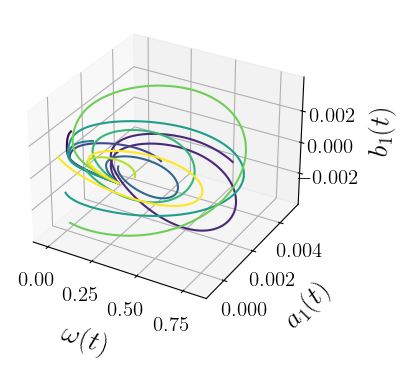

In [2]:
# Define the constants that will vary
pi = np.pi
g = 9.81  # Gravitational acceleration (m / s^2)
r_range = (0.3, 0.7)       # Range for radius of the wheel (m)
q1_range = (0.0001, 0.0005)  # Range for water inflow rate (m^3 / s)
I_range = (0.05, 0.2)      # Range for moment of inertia (kg * m^2)
nu_range = (0.01, 0.1)     # Range for viscous damping coefficient (kg / m / s)
K_range = (0.01, 0.1)      # Range for water leakage rate (1 / s)

# Number of values to generate
num_values = 200  # Generate 6 values in each range
r_values = np.random.uniform(r_range[0], r_range[1], num_values)
q1_values = np.random.uniform(q1_range[0], q1_range[1], num_values)
I_values = np.random.uniform(I_range[0], I_range[1], num_values)
nu_values = np.random.uniform(nu_range[0], nu_range[1], num_values)
K_values = np.random.uniform(K_range[0], K_range[1], num_values)

# Define the chaotic wheel system ODEs
def chaotic_wheel_system(t, y, r, q_1, I, nu, K):
    omega, a_1, b_1 = y
    dydt = [
        (pi * r * g / I) * a_1 - (nu / I) * omega,  # d(omega)/dt
        omega * b_1 - K * a_1,                      # d(a_1)/dt
        q_1 - K * b_1 - omega * a_1                 # d(b_1)/dt
    ]
    return dydt

# Initial conditions
omega_0 = 0.3   # initial angular velocity
a_1_0 = 0.00001 # initial a_1
b_1_0 = 0.00001 # initial b_1
y0 = [omega_0, a_1_0, b_1_0]

# Time span for the simulation
t_span = (0, 20)  # simulate from t=0 to t=500
t_eval = np.linspace(0,20, 200)
#t_span = (0,100)
#t_eval = np.linspace(0,100,1000)
# Initialize lists to store results
colors = plt.cm.viridis(np.linspace(0, 1, 10))
fig = plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['text.usetex'] = True  
ax = fig.add_subplot(111, projection='3d')
solutions = []
p = []   
dq = []  
for i, (r, q_1, I, nu, K) in enumerate(zip(r_values, q1_values, I_values, nu_values, K_values)):
    sol = solve_ivp(chaotic_wheel_system, t_span, y0, t_eval=t_eval, args=(r, q_1, I, nu, K))
    solutions.append(sol)  
    p.extend(np.column_stack(( [[r, q_1, I, nu, K , g]] * len(sol.t),sol.y[0], sol.y[1], sol.y[2],  )))  # Store [omega(t), a_1(t), b_1(t)]

    for omega, a_1, b_1 in zip(sol.y[0], sol.y[1], sol.y[2]):
        dq.append([
            ((pi * r * g / I) * a_1 - (nu / I) * omega),  # d(omega)/dt
            omega * b_1 - K * a_1,                      # d(a_1)/dt
            q_1 - K * b_1 - omega * a_1                 # d(b_1)/dt
        ])
    if i < 10:
        ax.plot(sol.y[0], sol.y[1], sol.y[2], label=f'r={r:.2f}, q_1={q_1:.6f}, I={I:.2f}, nu={nu:.2f}, K={K:.2f}', color=colors[i])
ax.xaxis.set_tick_params(width=1, labelsize=15, pad = 5)
ax.yaxis.set_tick_params(width=1, labelsize=15, pad = 5)
ax.zaxis.set_tick_params(width=1, labelsize=15, pad = 5)
ax.set_xlabel('$\omega(t)$', fontsize=20, labelpad=15)
ax.set_ylabel('$a_1(t)$', fontsize=20, labelpad=15)
ax.set_zlabel('$b_1(t)$', fontsize=20, labelpad=15)
#ax.legend()
#plt.savefig('chaotic_water_traj.png', dpi=300, bbox_inches='tight')
#plt.savefig('chaotic_water_traj.eps', dpi=300, bbox_inches='tight')
plt.show()


In [3]:
p  = np.array(p)   
dq = np.array(dq)
dq = dq[:,0].reshape(-1,1)

r     = p[:,0].reshape(-1,1)
q1    = p[:,1].reshape(-1,1)
I     = p[:,2].reshape(-1,1)
nu    = p[:,3].reshape(-1,1)
K     = p[:,4].reshape(-1,1)

dq  = dq/ K**2
#dq  = dq/(nu/I)**2
# Print out shapes for verification
print(f"Shape of p: {p.shape}")
print(f"Shape of dq (dw_1): {dq.shape}")
valid_rows = np.all(p >= 0, axis=1)
# Filter out the invalid rows from p and dq
p_filtered = p[valid_rows]
dq_filtered = dq[valid_rows]
# Output the filtered results
print('Filtered p:', p_filtered.shape)
print('Filtered dq:', dq_filtered.shape)

Shape of p: (40000, 9)
Shape of dq (dw_1): (40000, 1)
Filtered p: (29197, 9)
Filtered dq: (29197, 1)


In [4]:
D_in = np.matrix(' 1 0 2 2 0 1 0 0 0;  0 -1 0 -1 -1 -2 -1 0 0 ; 0 1 1 1 0 0 0 1 1 ')
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows   = np.shape(D_in)[0]
    num_cols   = np.shape(D_in)[1]
    Din1, Din2 = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2 = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1 = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
num_basis = D_in.shape[1] - matrix_rank(D_in)
basis_matrices = calc_basis(D_in,num_basis)
basis_matrices[3:6,:] = -basis_matrices[3:6,:]
print("Basis vectors from null space:")
print(basis_matrices)

Rank of D_in: 3
D_in matrix:
 [[ 1  0  2  2  0  1  0  0  0]
 [ 0 -1  0 -1 -1 -2 -1  0  0]
 [ 0  1  1  1  0  0  0  1  1]]
Basis vectors from null space:
[[ 2.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 2.  1. -1.  0. -1.  0.  0.  0.  0.]
 [ 5.  2. -2.  0.  0. -1.  0.  0.  0.]
 [-2. -1.  1. -0. -0. -0.  1. -0. -0.]
 [ 2. -0. -1. -0. -0. -0. -0.  1. -0.]
 [ 2. -0. -1. -0. -0. -0. -0. -0.  1.]]


In [5]:
def calc_pi(a, basis_matrices,X):
    coef_pi = np.dot(a, basis_matrices)  # Computes the weighted sum of basis matrices
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat

def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat

In [6]:
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape

    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]

    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [7]:
def MI_input_output(para_p,basis_matrices,dq,p,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # Treat warnings as errors
        a_list = [tuple(para_p[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_p_list = [calc_pi(a, basis_matrices, p) for a in a_list]
            pi_p = np.array(np.column_stack(pi_p_list))
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    if np.any(np.isnan(pi_p)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    MI = MI_d_binning(np.array(pi_p), np.array(dq), 50)

    return -MI

In [8]:
num_input      = 2  # Since num_input is always 1
num_para_p     = num_basis * num_input  # Number of parameters for para_p
num_para_total = num_para_p 
print('Number of parameters:', num_para_total)

# Define lower and upper bounds for para
lower_bounds = [-2] * num_para_total  # Adjust bounds if needed
upper_bounds = [2] * num_para_total
bounds = [lower_bounds, upper_bounds]

# CMA-ES options
options = {
    'bounds': bounds,
    'maxiter': 100,  # Maximum number of iterations
    'tolx': 1e-4,      # Tolerance for solution variability
    'tolfun': 1e-4,    # Tolerance for function value changes
    'popsize': 100,    # Population size
}

# Initialize the CMA-ES optimizer
es = CMAEvolutionStrategy([0.1] * num_para_total, 0.5, options)

# Run the optimization loop
while not es.stop():
    solutions = es.ask()  # Generate candidate solutions
    
    
    # Evaluate the objective function for each solution (para_p, para_t)
    es.tell(solutions, [
        MI_input_output(para_p, basis_matrices, dq_filtered,  p_filtered, num_basis, num_input)
        for para_p in solutions
    ])
    es.disp()  # Display current optimization status

# Print final results
es.result_pretty()
optimized_params = es.result.xbest  # Best parameters found
optimized_MI = es.result.fbest  # Best MI value found
optimized_para_p = optimized_params[:num_para_p]

# Output the optimized results
print('Optimized para_p:', optimized_para_p)
print('Optimized Mutual Information:', optimized_MI)


Number of parameters: 12
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 12 (seed=876343, Mon Nov  4 18:32:36 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 -4.368839180393840e-01 1.0e+00 5.80e-01  5e-01  6e-01 0:01.0
    2    200 -5.928147361384415e-01 1.3e+00 6.48e-01  6e-01  7e-01 0:02.0
    3    300 -4.890526995182229e-01 1.4e+00 6.97e-01  6e-01  8e-01 0:03.1
    6    600 -5.275015709213120e-01 2.1e+00 8.90e-01  7e-01  1e+00 0:06.3
   10   1000 -5.748265493800888e-01 3.0e+00 9.80e-01  7e-01  1e+00 0:10.5
   15   1500 -6.024498568451397e-01 4.4e+00 8.78e-01  5e-01  9e-01 0:15.9
   21   2100 -7.392137006922450e-01 6.4e+00 7.96e-01  3e-01  7e-01 0:22.2
   28   2800 -7.940050268481267e-01 8.6e+00 7.58e-01  2e-01  5e-01 0:29.4
   36   3600 -8.883882158819123e-01 9.6e+00 6.62e-01  1e-01  4e-01 0:37.6
   45   4500 -9.261111622330294e-01 1.3e+01 5.33e-01  7e-02  3e-01 0:47.0
   55   5500 -9.649966335936853e-01 2.0e+01 5.35e-01  5e-02  2e-01 0:

In [9]:
a_list = [tuple(optimized_para_p[i*num_basis:(i+1)*num_basis]) for i in range(num_input)]
print('a_list:',a_list)
a1 = np.array(a_list[0])
a2 = np.array(a_list[1])
a1_normalized = a1 / a1[4]
a2_normalized = a2
a2_normalized = a2_normalized/a2_normalized[3]
a_list[0] = np.round(tuple(a1_normalized),2)
a_list[1] = np.round(tuple(a2_normalized),2)
print('a_list:',a_list)

# Step 1: Compute coef_pi for each a in a_list
coef_pi_list = [np.dot(a, basis_matrices) for a in a_list]

# Step 2 & 3: Normalize each coef_pi by its own smallest absolute value
normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    #max_abs_value = np.max(np.abs(coef_pi))
    #normalized_coef_pi = coef_pi / max_abs_value
    normalized_coef_pi  = np.round(coef_pi,0)
    normalized_coef_pi_list.append(normalized_coef_pi)

# Print the normalized coef_pi values
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    print(f'coef_pi{i+1}', normalized_coef_pi)

a_list: [(0.20693384093634615, 0.5726242737326274, -0.47602796743777864, -0.17711610015188536, 0.4686672601423949, 0.0086032767276024), (-0.31855421039627985, 0.5178589553720953, 0.060698474934510534, 0.32392446310047485, -0.05871669041856573, 0.003453198080954543)]
a_list: [array([ 0.44,  1.22, -1.02, -0.38,  1.  ,  0.02]), array([-0.98,  1.6 ,  0.19,  1.  , -0.18,  0.01])]
coef_pi1 [[ 1. -0. -1. -0. -1.  1. -0.  1.  0.]]
coef_pi2 [[-0.  0. -1.  1. -2. -0.  1. -0.  0.]]


In [10]:
import numpy as np
variables_p = ['r','q_1','I','\\nu','K','g', '\\omega(t)','a_1(t)' , 'b_1(t)'];

omega_p = np.array(normalized_coef_pi_list)
omega_p = np.array(omega_p).reshape(-1, len(variables_p))

def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            value = np.round(value,1)
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

p_lab = create_labels(omega_p, variables_p)
from IPython.display import Math, display
for j, label in enumerate(p_lab):
    #print(f'Pi_q_lab[{j}] = {label}')
    print(f'Pi_q_lab[{j}]=') 
    display(Math( label ))
    

Pi_q_lab[0]=


<IPython.core.display.Math object>

Pi_q_lab[1]=


<IPython.core.display.Math object>

In [11]:
import numpy as np
from numpy.linalg import lstsq
from IPython.display import Math, display

# Function to calculate residuals and solve the system
def solve_and_check_residuals(gamma_matrix, rhs_matrix):
    # Solve the system
    C_solution, residuals, rank, singular_values = lstsq(gamma_matrix, rhs_matrix, rcond=None)
    # Calculate residuals
    residual_check = np.dot(gamma_matrix, C_solution) - rhs_matrix
    residual_check = np.round(residual_check, 1)
    return C_solution, residual_check

# Function to print LaTeX labels
def print_c_latex_labels(C_solution, variables_c):
    c_labels = create_labels(np.round(C_solution, 1), variables_c)
    labels = ['t_c', 'm_c']
    for j, label in enumerate(c_labels):
        print(f'{labels[j]} =')
        display(Math(label))
# Function to print LaTeX labels
def print_r_latex_labels(residual_check, variables_c):
    r_labels = create_labels(np.round(residual_check, 1), variables_c)
    for j, label in enumerate(r_labels):
        print(f'Pi_lab[{j}]=') 
        display(Math( label ))
def normalize_residual_rows(residual_matrix):
    normalized_residual = np.zeros_like(residual_matrix)
    for i in range(residual_matrix.shape[0]):
        max_val = np.max(np.abs(residual_matrix[i]))  # Find the largest absolute value in the row
        if max_val != 0:  # Avoid division by zero
            normalized_residual[i] = residual_matrix[i] / max_val
    return normalized_residual
        
# Initialize empty lists for gamma and RHS matrices
gamma_matrix = []
rhs_matrix = []

# Define the number of columns for D_in and num_p
num_p = 6
# For each Pi group, extract gamma and the RHS and store them in the matrices
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    gamma = (D_in[:, num_p:] * (normalized_coef_pi[:,num_p:].T)) 
    gamma_matrix.append(np.array(gamma).flatten()) 
    rhs   = -np.array(normalized_coef_pi[:,:num_p])
    rhs_matrix.append(np.array(rhs))
##Non-dimensional output \Pi_o
gamma_matrix.append(np.array([0, -2, 0]))
rhs_matrix.append(np.array([0, 0, -2, 2, 0, 0]))
gamma_matrix = np.array(gamma_matrix)
rhs_matrix   = np.vstack(rhs_matrix)
print('rhs_matrix', rhs_matrix)

# Find columns that are entirely zero
non_zero_columns        = np.any(gamma_matrix != 0, axis=0)
filtered_gamma_matrix   = gamma_matrix[:, non_zero_columns]
print('filtered_gamma_matrix', filtered_gamma_matrix)

rhs_matrix_o            = rhs_matrix
filtered_gamma_matrix_o = filtered_gamma_matrix

# Iteratively remove rows with large residuals
while True:
    C_solution, residual_check = solve_and_check_residuals(filtered_gamma_matrix, rhs_matrix)
    print('Current residuals = \n', residual_check)
    
    # Find rows with residuals larger than 1e-3
    large_residuals = np.abs(residual_check) > 1e-2
    rows_with_large_residuals = np.where(np.any(large_residuals, axis=1))[0]
    
    if len(rows_with_large_residuals) == 0:
        # No significant residuals remain, break the loop
        print("No residuals larger than 1e-3 found. Solution is stable.")
        break
    row_to_remove = np.random.choice(rows_with_large_residuals)
    filtered_gamma_matrix = np.delete(filtered_gamma_matrix, row_to_remove, axis=0)
    rhs_matrix = np.delete(rhs_matrix, row_to_remove, axis=0)
    
print("Final solution:")
print(C_solution)
variables_c = ['r', 'q_1', 'I', '\\nu', 'K', 'g']
print_c_latex_labels(C_solution, variables_c)

residual_check            = np.dot(filtered_gamma_matrix_o, C_solution) - rhs_matrix_o
non_zero_rows             = np.any(residual_check != 0, axis=1)
filtered_residual_check   = residual_check[non_zero_rows,:]
normalized_final_residual = normalize_residual_rows(filtered_residual_check)
print("Final residual:")
print_r_latex_labels(normalized_final_residual, variables_c)


rhs_matrix [[-1.  0.  1.  0.  1. -1.]
 [ 0. -0.  1. -1.  2.  0.]
 [ 0.  0. -2.  2.  0.  0.]]
filtered_gamma_matrix [[ 0.  1.]
 [-1.  0.]
 [-2.  0.]]
Current residuals = 
 [[ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.6  1.6 -1.6  0. ]
 [ 0.   0.   0.8 -0.8  0.8  0. ]]
Current residuals = 
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
No residuals larger than 1e-3 found. Solution is stable.
Final solution:
[[ 0.  0. -1.  1. -2.  0.]
 [-1.  0.  1.  0.  1. -1.]]
t_c =


<IPython.core.display.Math object>

m_c =


<IPython.core.display.Math object>

Final residual:
Pi_lab[0]=


<IPython.core.display.Math object>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


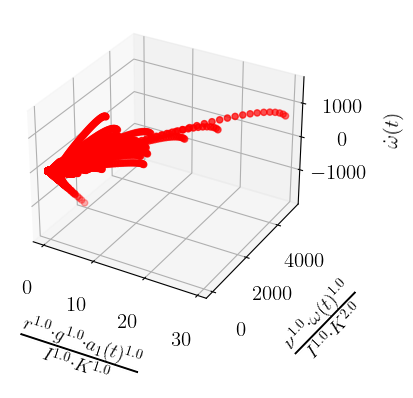

In [12]:
input_list = [calc_pi_omega(np.array(omega), p_filtered) for omega in normalized_coef_pi_list]
input_tauw = np.column_stack(input_list)
fig = plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.usetex'] = True  
ax = fig.add_subplot(111, projection='3d')
ax.scatter( input_tauw[:,0], input_tauw[:,1], dq_filtered, c='r', marker='o')
def prepare_label(label):
    if '$' in label:
        return r'{}'.format(label)
    return label

ax.set_xlabel(p_lab[0], fontsize=20, labelpad=20)
ax.set_ylabel(p_lab[1], fontsize=20, labelpad=25)
ax.set_zlabel(r'$\dot \omega(t)$', fontsize=15, labelpad=20)

ax.xaxis.set_tick_params(width=1, labelsize=15)
ax.yaxis.set_tick_params(width=1, labelsize=15)
ax.zaxis.set_tick_params(width=1, labelsize=15)
ax.tick_params(axis='both', which='major', labelsize=15, pad=10)
ax.grid(True)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

plt.savefig('chaotic_dimensionless.png', dpi=300, bbox_inches='tight')
plt.savefig('chaotic_dimensionless.eps', dpi=300, bbox_inches='tight')
plt.show()